# APPLICATION 10 - NEURAL STYLE NETWORK

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t()) 
    return m

def denormalize_img(inp):
    inp     = inp.numpy().transpose((1, 2, 0))
    mean    = np.array([0.485, 0.456, 0.406])
    std     = np.array([0.229, 0.224, 0.225])
    inp     = std * inp + mean
    inp     = np.clip(inp, 0, 1)
    return inp

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features

In [5]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img     = get_image('content.jpg', img_transform)
style_img       = get_image('style.jpg', img_transform)
generated_img   = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder   = FeatureExtractor().to(device)

for p in encoder.parameters():
    p.requires_grad = False

In [6]:
content_weight = 1
style_weight = 100

for epoch in range(500):
    
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w) 

    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: 0.0000	Style Loss: 1876.1628
Epoch [10]	Content Loss: 0.4513	Style Loss: 1495.8291
Epoch [20]	Content Loss: 0.9162	Style Loss: 1283.4924
Epoch [30]	Content Loss: 1.2886	Style Loss: 1132.3129
Epoch [40]	Content Loss: 1.5866	Style Loss: 1015.4857
Epoch [50]	Content Loss: 1.8256	Style Loss: 921.3336
Epoch [60]	Content Loss: 2.0262	Style Loss: 842.8416
Epoch [70]	Content Loss: 2.1962	Style Loss: 775.8549
Epoch [80]	Content Loss: 2.3484	Style Loss: 717.6972
Epoch [90]	Content Loss: 2.4827	Style Loss: 666.8154
Epoch [100]	Content Loss: 2.6012	Style Loss: 621.7711
Epoch [110]	Content Loss: 2.7060	Style Loss: 581.5225
Epoch [120]	Content Loss: 2.8003	Style Loss: 545.2792
Epoch [130]	Content Loss: 2.8837	Style Loss: 512.3268
Epoch [140]	Content Loss: 2.9599	Style Loss: 482.1216
Epoch [150]	Content Loss: 3.0294	Style Loss: 454.2315
Epoch [160]	Content Loss: 3.0913	Style Loss: 428.3515
Epoch [170]	Content Loss: 3.1494	Style Loss: 404.2357
Epoch [180]	Content Loss: 3.2024	S

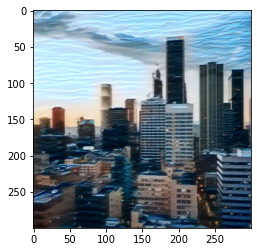

In [11]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)